# Sec Recon Analyses

Here we perform different analyses to test the quality of secRecon

In [1]:
import datetime
import pickle
import networkx as nx

import re
import pandas as pd
import numpy as np
from Bio import Entrez
import Request_Utilis
from google_sheet import GoogleSheet
from collections import defaultdict
from scipy import interpolate

# Plotting libraries
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
from itertools import product

# Warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
##### ----- Generate datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
Sec_Recon_SPREADSHEET_ID = '1L6qQQs48OdFd-mJcVqov_rSDoV90Ta0kib6UpL81OJQ'

# Initialize the GoogleSheet object
sec_recon_gsheet_file = GoogleSheet(Sec_Recon_SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from SecRecon
sec_genes_sheet = 'SecRecon'
ontology_sheet = 'Ontology'

sec_genes = sec_recon_gsheet_file.read_google_sheet(sec_genes_sheet)
ontology = sec_recon_gsheet_file.read_google_sheet(ontology_sheet)

### 1. Preprocessing of the data

In this section we'll use the networks generated in the Network_visualization notebook to visualize experimental data from a CHO High vs Low dataset

In [3]:
# Load datasets
cho_vs_plasma_prot = pd.read_excel('Data/cho_vs_plasma/1-s2.0-S1096717624000521-mmc3.xlsx',
                                   sheet_name = 'Proteome DE proteins')

cho_vs_plasma_rna = pd.read_excel('Data/cho_vs_plasma/1-s2.0-S1096717624000521-mmc3.xlsx',
                                   sheet_name = 'Transcriptome DE')

In [21]:
# Define dataset and condition
data_type = ['rna','prot']

data = data_type[0]

if data == 'prot':
    df = cho_vs_plasma_prot
    cond = 'FC PCD/CHO'
if data == 'rna':
    df = cho_vs_plasma_rna
    cond = 'Fold-Change PCD/CHO'

In [22]:
# Load gene_dict from SecRecon

with open('gene_dict.pkl', 'rb') as f:
    gene_dict = pickle.load(f)

In [23]:
# Load G string for plotting
G = nx.read_graphml('Network/sec_recon_network.graphml')

In [24]:
# Map Mouse genes to Human genes

dict_mouse_human = dict(zip(sec_genes['MOUSE GENE SYMBOL'], sec_genes['GENE SYMBOL']))
df['Human_Genes'] = df['Mmus_Genes'].map(dict_mouse_human)

In [25]:
# Filtering

# Filter rows where 'Human_Genes' is not NaN
filtered_df = df[df['Human_Genes'].notna()]

# Filter the dictionary based on the filtered_df
filtered_gene_dict = {gene: info for gene, info in gene_dict.items() if gene in filtered_df['Human_Genes'].values}

# Filter the graph G based on the filtered_gene_dict
nodes_to_remove = [node for node in G.nodes if node not in filtered_gene_dict]
G.remove_nodes_from(nodes_to_remove)

In [26]:
# Normalization

# Shift and Normalize the 'Fold-Change PCD/CHO' Values
if cond == 'Fold-Change PCD/CHO':
    shift_constant = abs(filtered_df[cond].min()) + 1  # Ensure the smallest value becomes 1
    shifted_values = filtered_df[cond] + shift_constant

    # Min-Max Scaling to Range [0, 1]
    min_val = shifted_values.min()
    max_val = shifted_values.max()
    normalized_values = (shifted_values - min_val) / (max_val - min_val)

    # Add the normalized values to the dataframe
    filtered_df['normalized_Fold-Change'] = normalized_values
    
     # Apply log transformation to 'FC PCD/CHO' column
    shift_constant = 1e-6  # Small constant to avoid zero
    filtered_df['log'] = np.log2(filtered_df['normalized_Fold-Change'] + shift_constant)

else:
    # Apply log transformation to 'FC PCD/CHO' column
    shift_constant = 1e-6  # Small constant to avoid zero
    filtered_df['log'] = np.log2(filtered_df[cond] + shift_constant)

min_val = 0.001
max_val = 0.035

filtered_df['normalized_log'] = ((filtered_df['log'] - filtered_df['log'].min()) / 
                                (filtered_df['log'].max() - filtered_df['log'].min())) * (max_val - min_val) + min_val


/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_35718/1801540466.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['normalized_Fold-Change'] = normalized_values
/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_35718/1801540466.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log'] = np.log2(filtered_df['normalized_Fold-Change'] + shift_constant)
/var/folders/_x/tfg8s2ks4n1ftkkwzp5sqjpc0000gn/T/ipykernel_35718/1801540466.py:28: SettingWithCopyWarning: 
A v

In [27]:
filtered_df

Mmus_Protein_Accession    Hsap_Protein_Accession Mmus_Genes  \
59                   NP_079724                 NP_003136       Ssr2   
76                NP_001020116                 NP_002817      Qsox1   
82                   NP_598580                 NP_116222   Ppp1r15b   
105               XP_006523926              NP_001129123    Eif2ak2   
116                  NP_065644                 NP_006293       Mogs   
...                        ...                       ...        ...   
4994              NP_001300863                       NaN      Calm1   
4995  NP_065062 : NP_001277438  NP_065171 : NP_001129389     Dolpp1   
5004  XP_017177311 : NP_796051  XP_011531013 : NP_056004     Exoc6b   
5037                 NP_032606              XP_016866362     Map3k5   
5048                 NP_765988                 NP_055095     Dnajc8   

      Average Murine log2  Average Human log2  Average CHO log2  \
59              14.136341           13.072358         11.423671   
76              10.378739           10.605546          0.005297   
82              11.966481           11.296025          0.671873   
105              8.327605            9.057580         -0.006869   
116             13.308278           11.781741         10.426051   
...                   ...                 ...               ...   
4994            11.232069            5.533465         11.795258   
4995             9.289947            9.624317          8.834494   
5004             6.317685            6.267665          7.678869   
5037             9.325855            8.708204          4.413638   
5048             9.819377            9.637576         10.471602   

      Average Plasma cells log2  Fold-Change PCD/CHO  Fold-Change CHO/PCD  \
59                    13.604350             4.533668            -4.533668   
76                    10.492142          1435.010278         -1435.010278   
82                    11.631253          1991.141632         -1991.141632   
105                    8.692593           415.718223          -415.718223   
116                   12.545009             4.343801            -4.343801   
...                         ...                  ...                  ...   
4994                   8.382767           -10.647855            10.647855   
4995                   9.457132             1.539688            -1.539688   
5004                   6.292675            -2.613883             2.613883   
5037                   9.017030            24.308556           -24.308556   
5048                   9.728477            -1.673799             1.673799   

      Fold-Change Murine/Human  ...  Unnamed: 15  Unnamed: 16  Unnamed: 17  \
59                    2.090696  ...          NaN          NaN          NaN   
76                   -1.170242  ...          NaN          NaN          NaN   
82                    1.591576  ...          NaN          NaN          NaN   
105                  -1.658611  ...          NaN          NaN          NaN   
116                   2.880934  ...          NaN          NaN          NaN   
...                        ...  ...          ...          ...          ...   
4994                 51.933843  ...          NaN          NaN          NaN   
4995                 -1.260827  ...          NaN          NaN          NaN   
5004                  1.035280  ...          NaN          NaN          NaN   
5037                  1.534375  ...          NaN          NaN          NaN   
5048                  1.134299  ...          NaN          NaN          NaN   

           Row       P-Value      Padj(BH)  Human_Genes  \
59        Ssr2  1.000001e-35  1.000001e-35         SSR2   
76       Qsox1  1.000001e-35  1.000001e-35        QSOX1   
82    Ppp1r15b  1.000001e-35  1.000001e-35     PPP1R15B   
105    Eif2ak2  1.000001e-35  1.000001e-35      EIF2AK2   
116       Mogs  1.000001e-35  1.000001e-35         MOGS   
...        ...           ...           ...          ...   
4994     Calm1  2.268184e-02  4.595400e-02        CALM1   
4995    Dolpp1  

In [28]:
# Extract positions from the graph
pos = {node: (float(data['x']), float(data['y'])) for node, data in G.nodes(data=True)}

In [29]:
for i,row in filtered_df.iterrows():
    g = row['Human_Genes']
    if g in gene_dict.keys():
        filtered_gene_dict[g]['Expression'] = float(row['normalized_log'])

In [30]:
# Discretize the size of the nodes by allocating the radius into 5 different categories


# Fit an interpolation function
x = filtered_df[cond]
y = filtered_df['normalized_log']
interp_func = interpolate.interp1d(x, y, fill_value="extrapolate")

# Define cutoff values for FC PCD/CHO
cutoff_values = [0, 1, 2, 8, 16, np.inf]

# Interpolate the cutoffs to normalized_log values
normalized_cutoffs = []
for cutoff in cutoff_values:
    if np.isfinite(cutoff):
        normalized_cutoffs.append(float(interp_func(cutoff)))
    else:
        normalized_cutoffs.append(cutoff)

# Create categories for node sizes
categories = {
    (-np.inf, normalized_cutoffs[1]): 0.005,
    (normalized_cutoffs[1], normalized_cutoffs[2]): 0.010,
    (normalized_cutoffs[2], normalized_cutoffs[3]): 0.015,
    (normalized_cutoffs[3], normalized_cutoffs[4]): 0.025,
    (normalized_cutoffs[4], np.inf): 0.035
}

In [31]:
def get_radius(value):
    for (low, high), radius in categories.items():
        if low <= value < high:
            return radius
    return 0.001  # Default small value if out of range

### 2. Plotting on secRecon Ontology

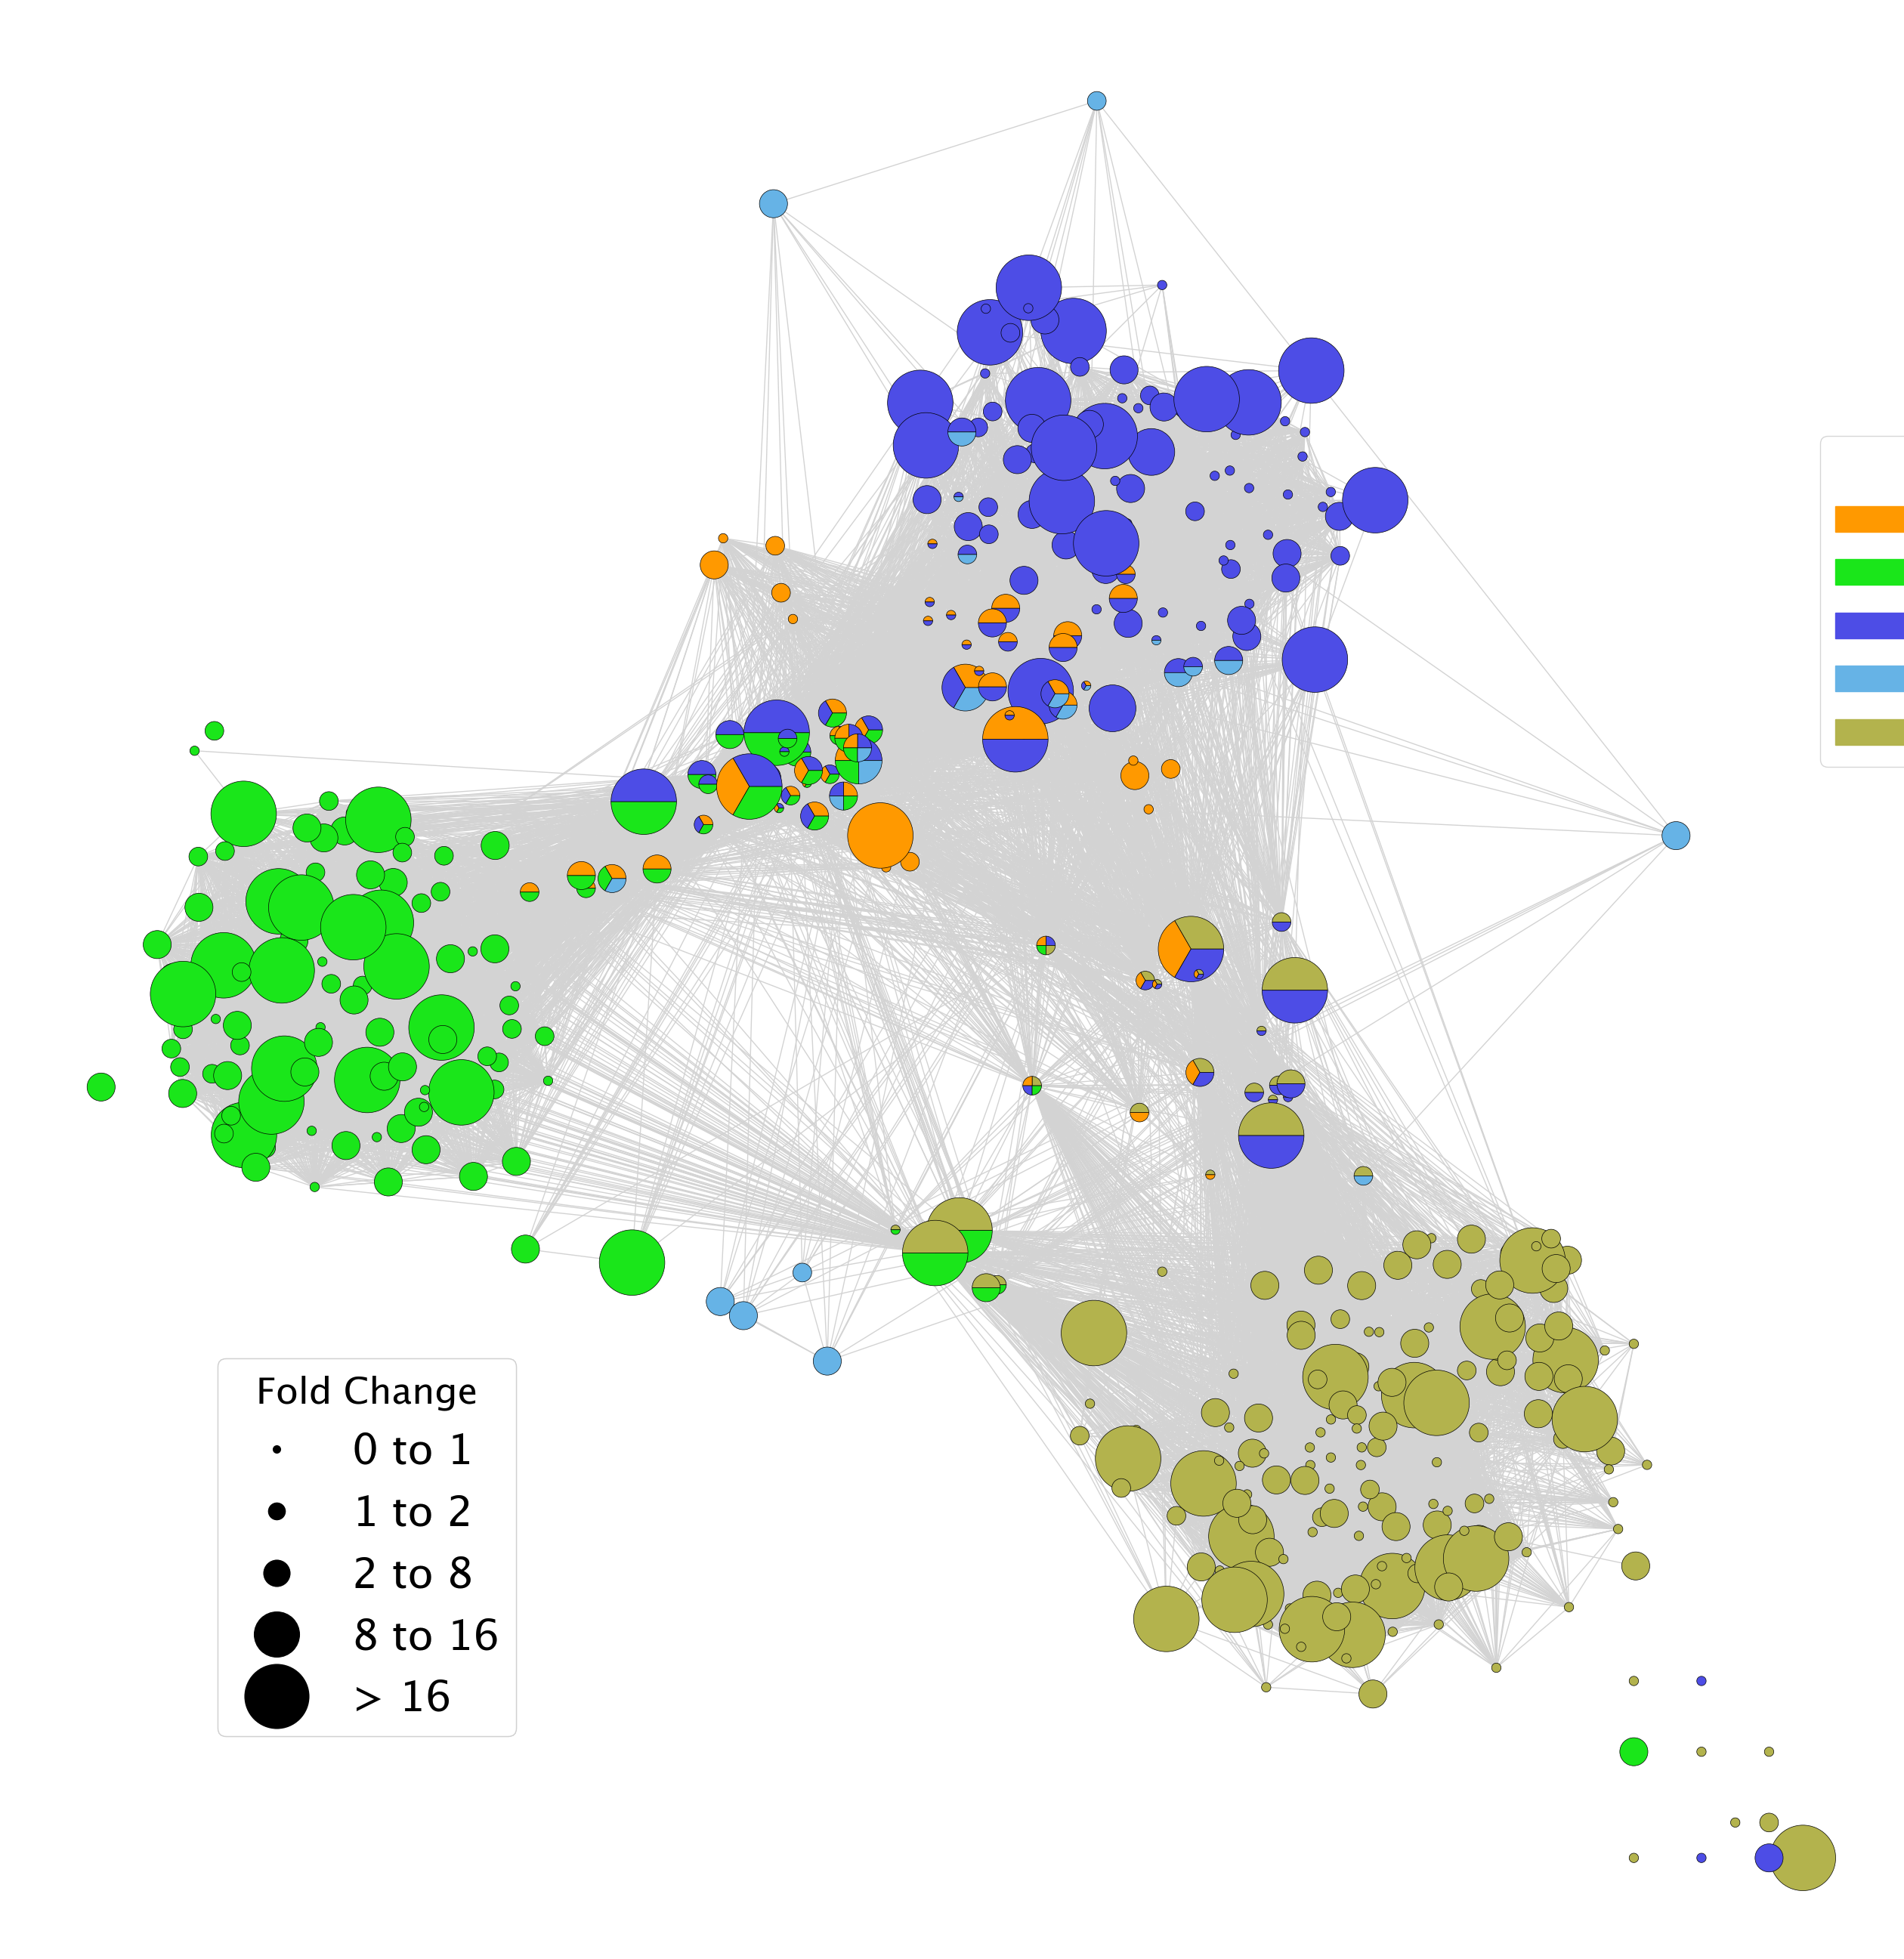

In [32]:
system_colors = {
    'Protein conformation': (1.0, 0.6, 0.0, 1.0),
    'Post-translational modifications': (0.1, 0.9, 0.1, 1.0), 
    'Proteostasis': (0.3, 0.3, 0.9, 1.0),
    'Translocation': (0.4, 0.7, 0.9, 1.0),
    'Vesicle trafficking': (0.7, 0.7, 0.3, 1.0)
}

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 1]

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey')#, 
                       #width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 2])

    
# Draw nodes as pie charts
for node, (x, y) in pos.items():
    systems = gene_dict[node]['systems']
    
    # Adjust the alpha value of each color
    colors = [system_colors[sys] for sys in systems]
    
    # Draw pie chart at node position with edgecolor and linewidth
    raw_radius = filtered_gene_dict[node]['Expression']
    radius = get_radius(raw_radius)
    ax.pie([1]*len(systems), colors=colors, radius=radius, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend for node colors
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in system_colors.items()]
color_legend = plt.legend(handles=legend_patches, prop={'size': 35}, loc='lower left', bbox_to_anchor=(0.95, 0.6), title="System" , title_fontsize=35)

# Create custom legend handles for node sizes
size_legend_patches = []
size_labels = ['0 to 1', '1 to 2', '2 to 8', '8 to 16', '> 16']
scaling_factor = 1800

for (low, high), radius, label in zip(categories.keys(), categories.values(), size_labels):
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=radius * scaling_factor, label=label)
    size_legend_patches.append(handle)

# Add the second legend for node sizes
size_legend = plt.legend(handles=size_legend_patches, prop={'size': 40}, loc='lower left', bbox_to_anchor=(0.1, 0.1), title="Fold Change", title_fontsize=35)

# Add both legends to the plot
ax.add_artist(color_legend)
ax.add_artist(size_legend)

plt.subplots_adjust(right=0.75)

plt.savefig(f'Network_cho_vs_plasma/secRecon_cho_vs_plasma_systems_{data}.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

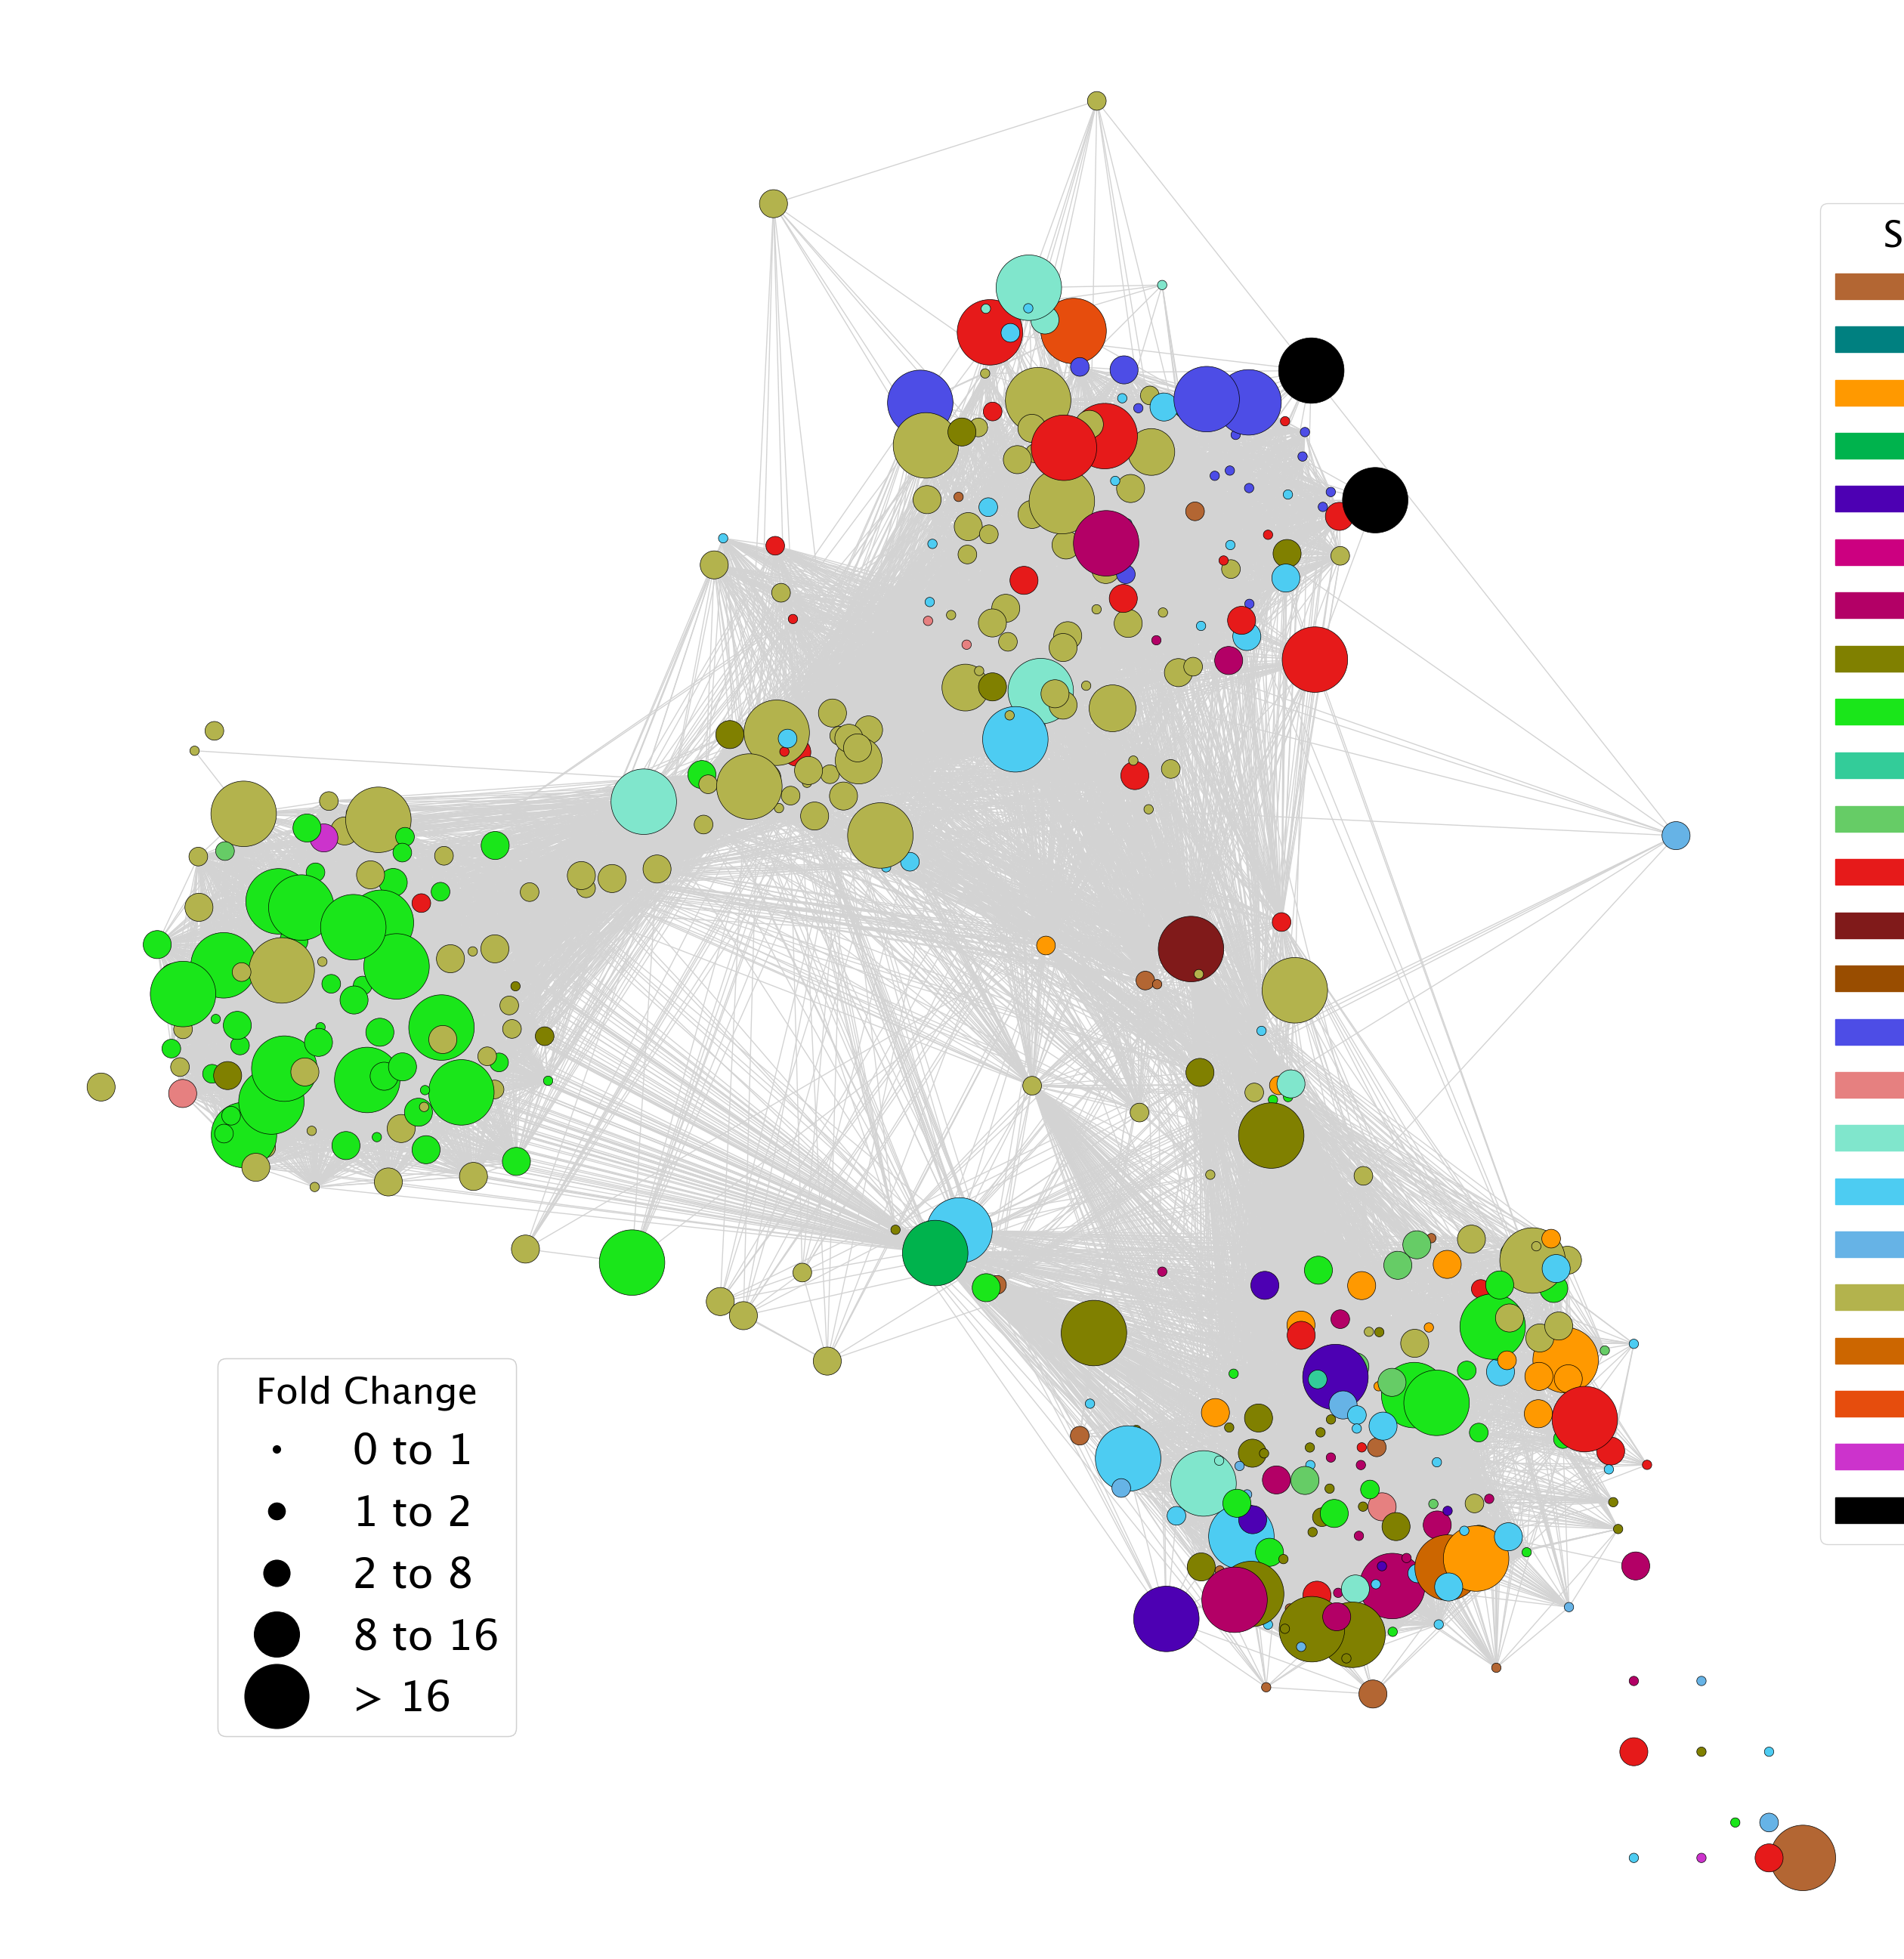

In [33]:
localization_colors = {
    'Actin Cytoskeleton': (0.7, 0.4, 0.2, 1.0),
    'Centrosome': (0.0, 0.5, 0.5, 1.0),
    'ERGIC': (1.0, 0.6, 0.0, 1.0),
    'Endosome': (0.0, 0.7, 0.3, 1.0), 
    'Recycling Endosome': (0.3, 0.0, 0.7, 1.0),
    'Late Endosome': (0.8, 0.0, 0.5, 1.0),
    'Early Endosome': (0.7, 0.0, 0.4, 1.0), 
    'Plasma Membrane': (0.5, 0.5, 0.0, 1.0), 
    'Golgi': (0.1, 0.9, 0.1, 1.0), 
    'cis-Golgi': (0.2, 0.8, 0.6, 1.0),
    'trans-Golgi': (0.4, 0.8, 0.4, 1.0), 
    'Nucleus': (0.9, 0.1, 0.1, 1.0),
    'Nucleolus': (0.5, 0.1, 0.1, 1.0),
    'Phagosome': (0.6, 0.3, 0.0, 1.0),
    'Proteasome': (0.3, 0.3, 0.9, 1.0),
    'Mitochondria': (0.9, 0.5, 0.5, 1.0),
    'Lysosome': (0.5, 0.9, 0.8, 1.0),  
    'Cytosol': (0.3, 0.8, 0.95, 1.0),
    'Cytoplasm': (0.4, 0.7, 0.9, 1.0),
    'Endoplasmic Reticulum': (0.7, 0.7, 0.3, 1.0),
    'Secreted': (0.8, 0.4, 0.0, 1.0),
    'Stress Granule': (0.9, 0.3, 0.05, 1.0),
    'Translation': (0.8, 0.2, 0.8, 1.0),
    'Unknown': (0.0, 0.0, 0.0, 1.0)
}

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 1]

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey')#, 
                       #width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 2])


# Draw nodes as pie charts
for node, (x, y) in pos.items():
    localizations = gene_dict[node]['subcellular_localization']
    
    # Adjust the alpha value of each color
    colors = [localization_colors[loc] for loc in localizations]
    
    # Draw pie chart at node position with edgecolor and linewidth
    raw_radius = filtered_gene_dict[node]['Expression']
    radius = get_radius(raw_radius)
    ax.pie([1]*len(systems), colors=colors, radius=radius, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in localization_colors.items()]
color_legend = plt.legend(handles=legend_patches, prop={'size': 35}, loc='lower left', bbox_to_anchor=(0.95, 0.2), title="Subcellular Localization" , title_fontsize=35)

# Create custom legend handles for node sizes
size_legend_patches = []
size_labels = ['0 to 1', '1 to 2', '2 to 8', '8 to 16', '> 16']
scaling_factor = 1800

for (low, high), radius, label in zip(categories.keys(), categories.values(), size_labels):
    handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=radius * scaling_factor, label=label)
    size_legend_patches.append(handle)

# Add the second legend for node sizes
size_legend = plt.legend(handles=size_legend_patches, prop={'size': 40}, loc='lower left', bbox_to_anchor=(0.1, 0.1), title="Fold Change", title_fontsize=35)

# Add both legends to the plot
ax.add_artist(color_legend)
ax.add_artist(size_legend)

plt.subplots_adjust(right=0.75)

plt.savefig(f'Network_cho_vs_plasma/secRecon_cho_vs_plasma_localization_{data}.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

### 3. Plotting on Protein-Protein Interactions

In [34]:
from pp_interactions import visualize_network

In [35]:
G_ppi = nx.read_graphml('Network/string_interactions_sec_recon.graphml')

# Filter the G PPI based on the filtered_gene_dict
nodes_to_remove = [node for node in G_ppi.nodes if node not in filtered_gene_dict]
G_ppi.remove_nodes_from(nodes_to_remove)

# Extract positions from the graph
pos = {node: (float(data['x']), float(data['y'])) for node, data in G_ppi.nodes(data=True)}

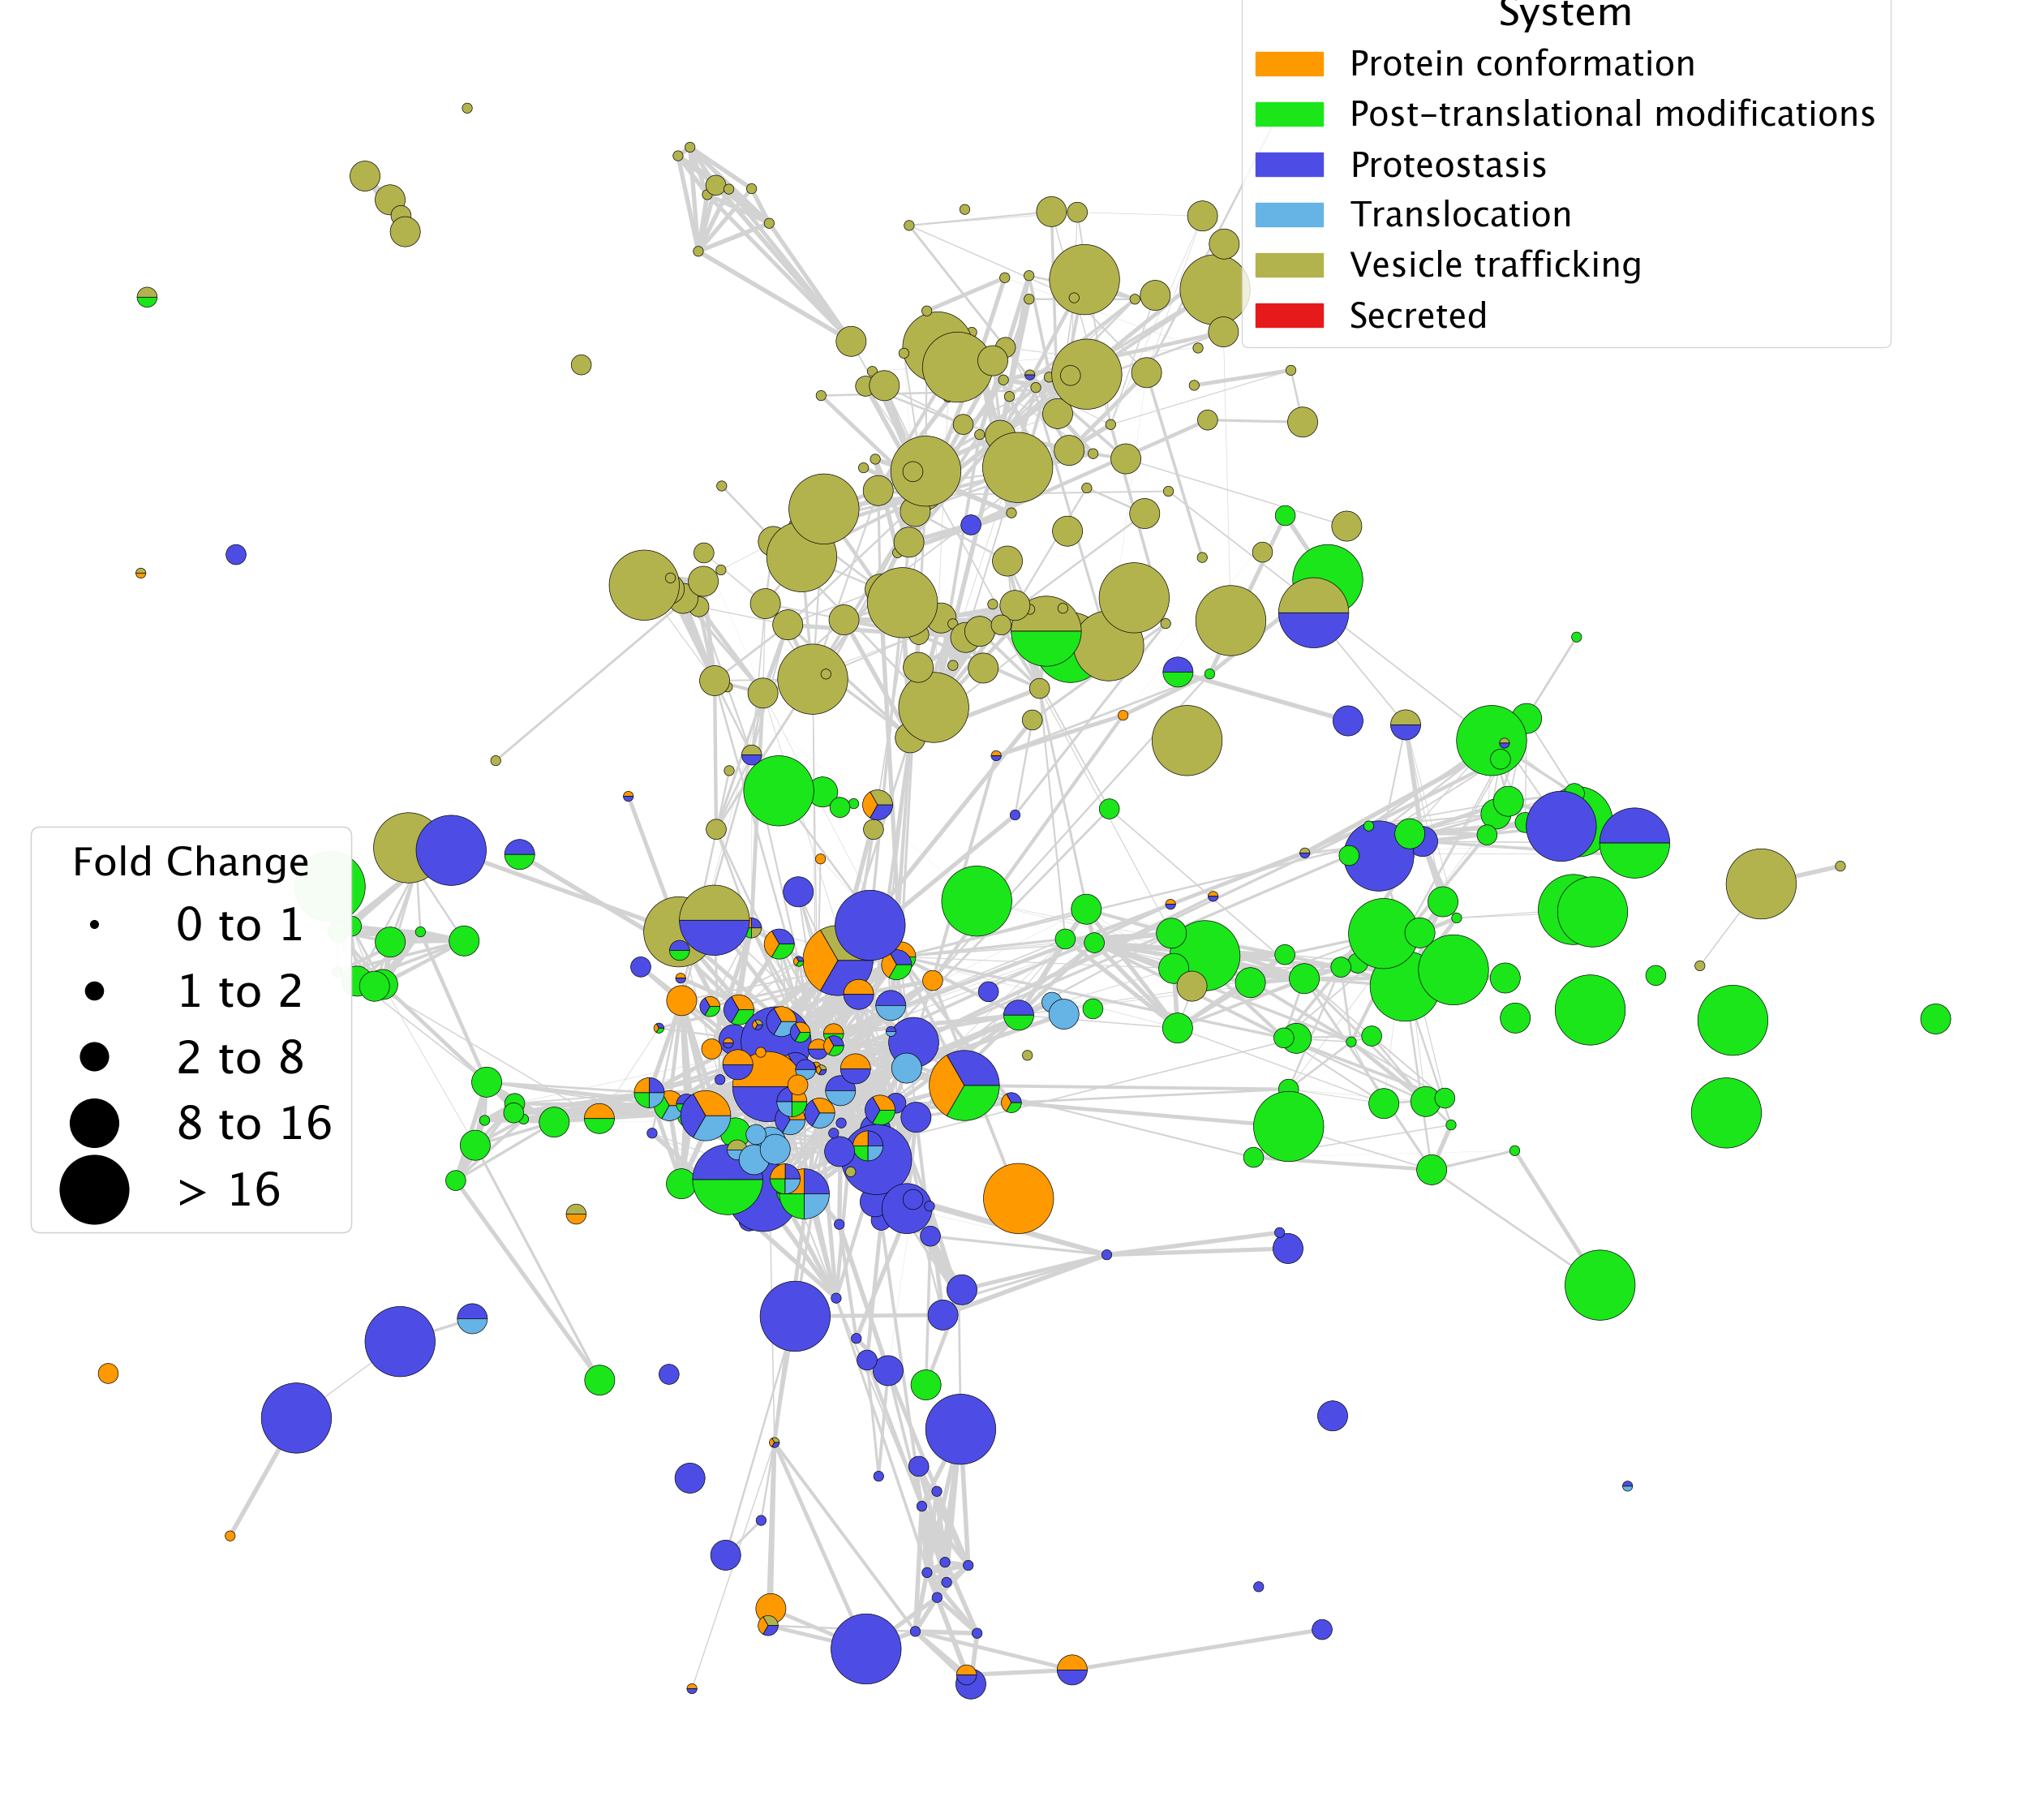

In [36]:
filename = f"Network_cho_vs_plasma/STRING_cho_vs_plasma_systems_{data}.png"
visualize_network(G_ppi, filtered_gene_dict, pos, filename=filename, node_size='exp', color_by='systems', legends=True, categories=categories)

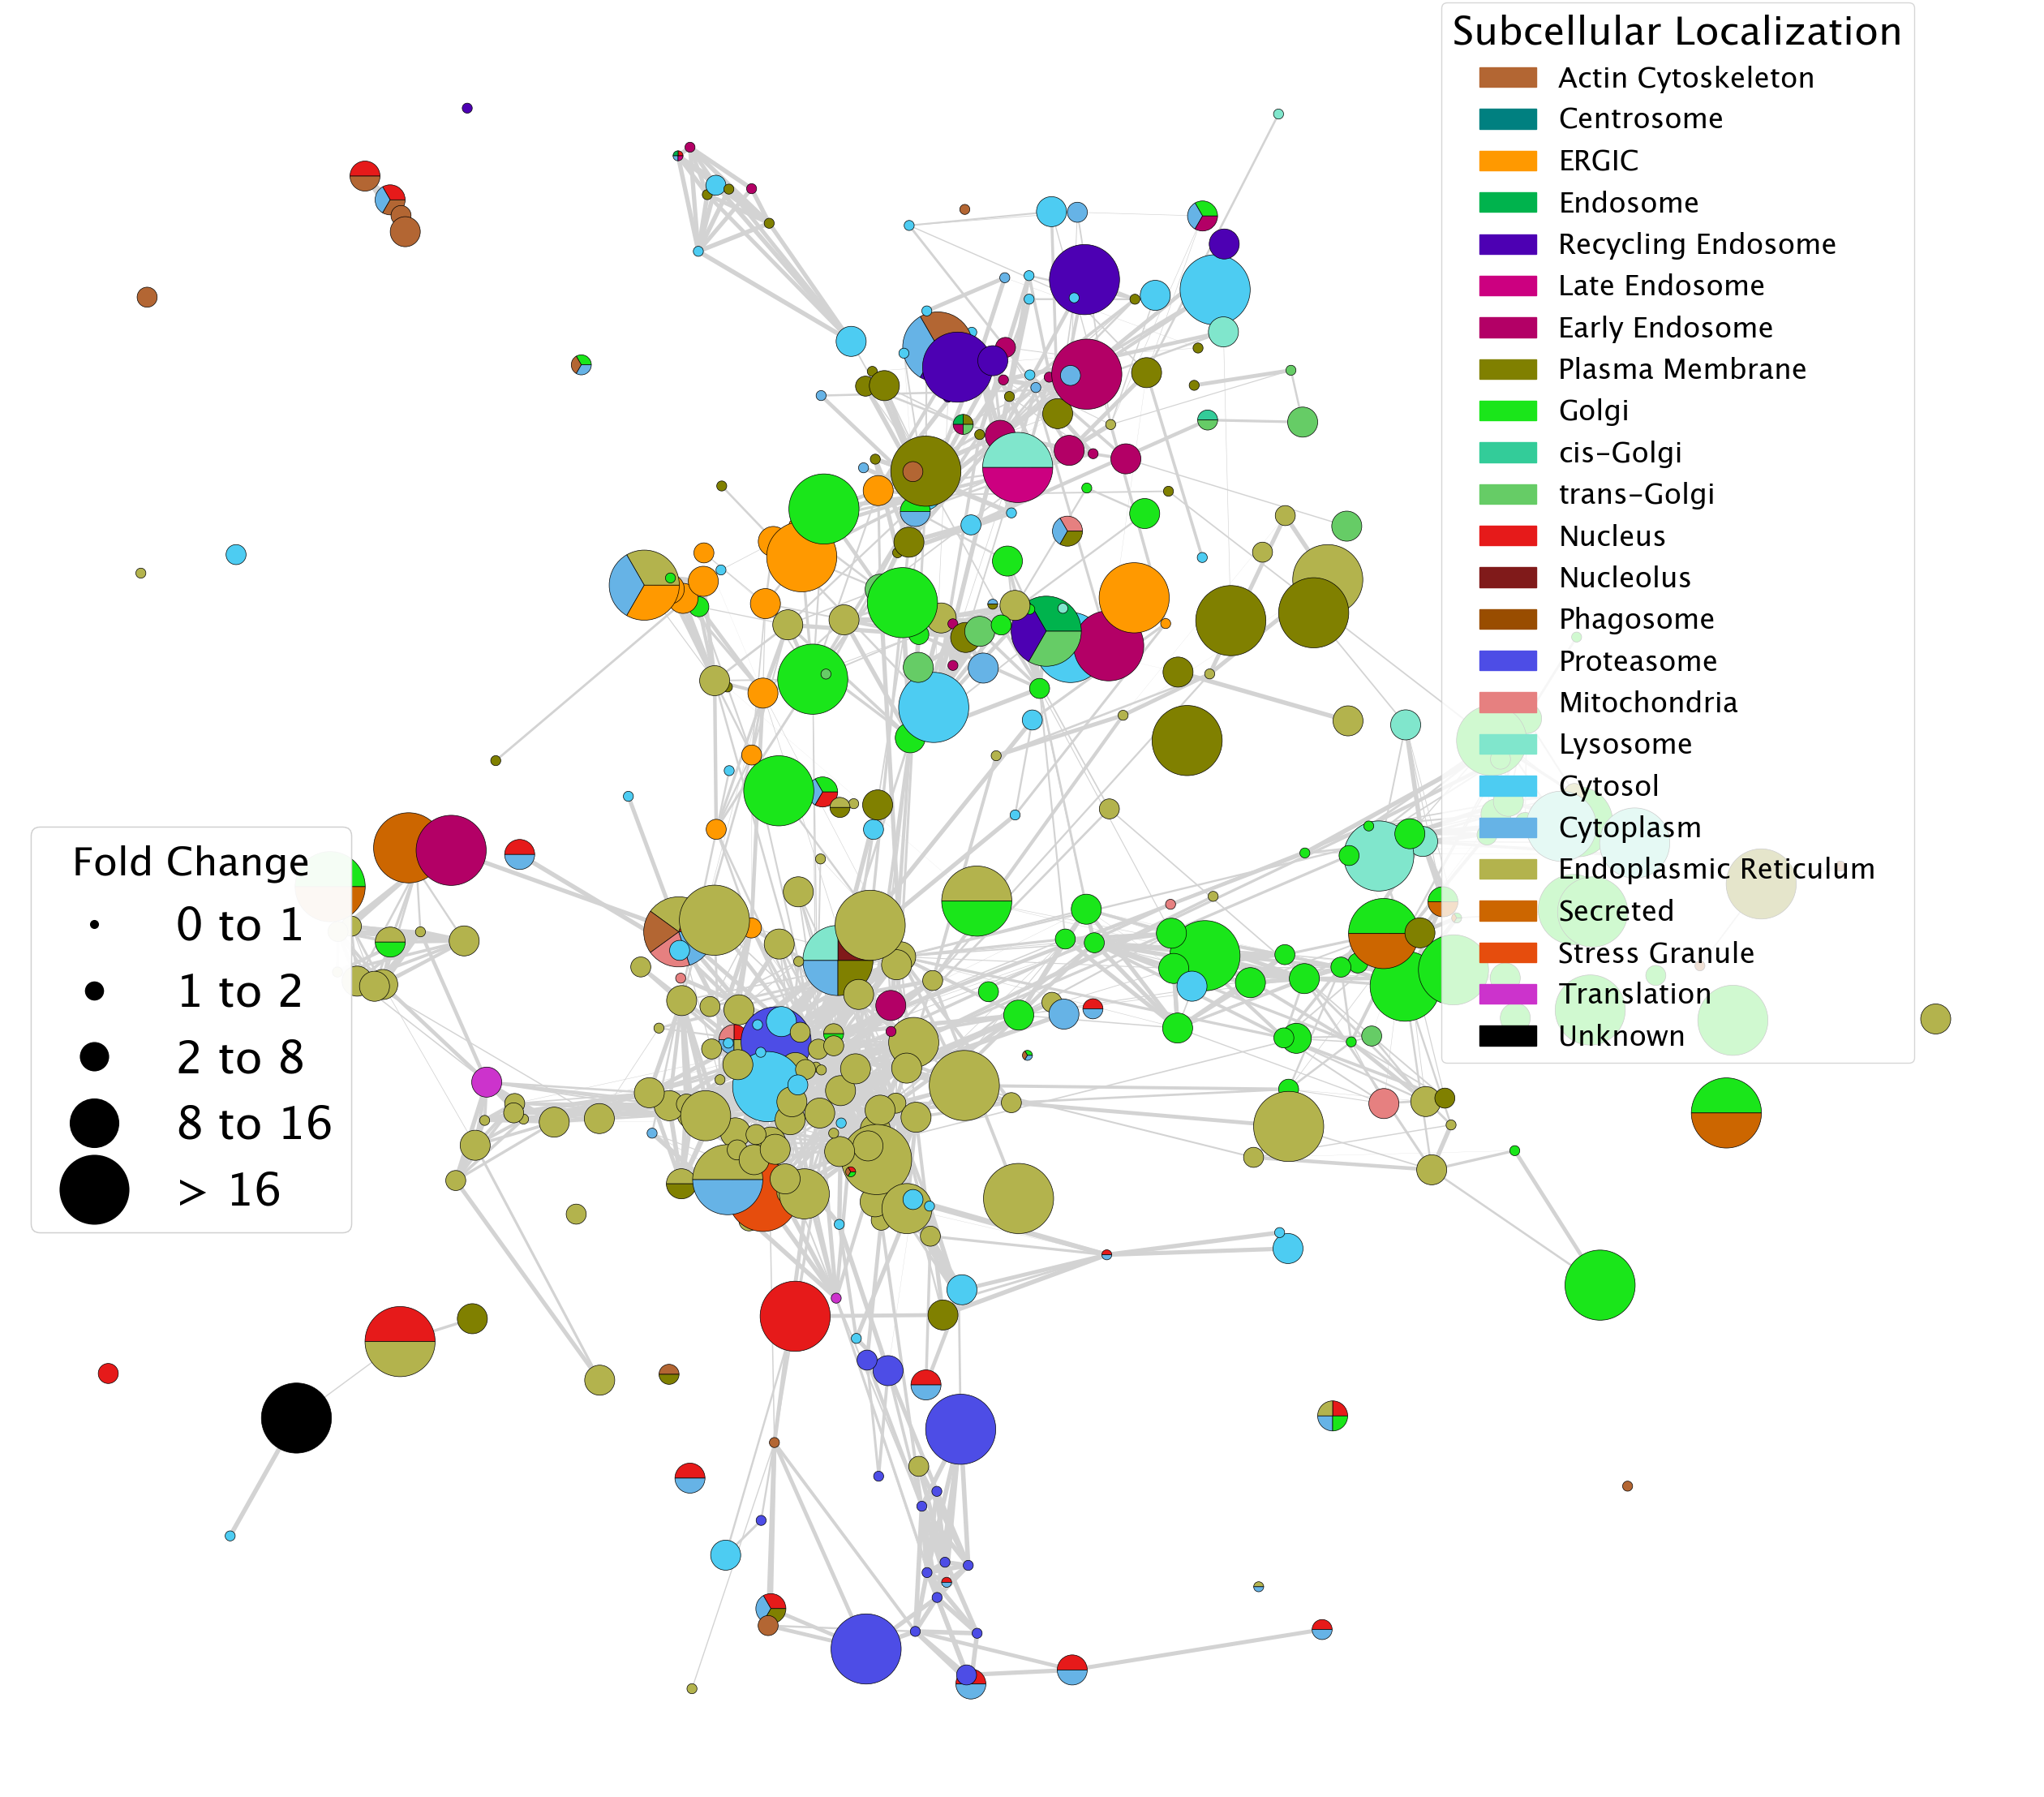

In [37]:
filename = f"Network_cho_vs_plasma/STRING_cho_vs_plasma_localization_{data}.png"
visualize_network(G_ppi, filtered_gene_dict, pos, filename=filename, node_size='exp', color_by='localization', legends=True, categories=categories)

In [ ]:
# Limitations:
# 20% representation of secRecon
# 50% in transcriptomics??